<a href="https://colab.research.google.com/github/phyml4e/PINNs/blob/main/Elasticity/Elasticity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**More information about this short introduction/code as well as the performance of some possible version of PINNs can be found in our paper:**

http://arxiv.org/abs/2206.13103

**For more information about PINNs in general see:**

https://arxiv.org/abs/1711.10561

**For more information about SciAnn library see:**

https://arxiv.org/abs/2005.08803

**SciAnn** is a library for the performing Physics-Informed Neural Network. More info can be found at www.sciann.com.



In [1]:
# !pip install sciann -q

     |████████████████████████████████| 168 kB 27.8 MB/s 
     |████████████████████████████████| 561 kB 52.1 MB/s 


**Importing the necessary  libraries and functions.**

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import sciann as sn
from sciann.utils.math import diff, sqrt, abs
import tensorflow as tf

---------------------- SCIANN 0.6.7.6 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 
TensorFlow Version: 2.8.2 
Python Version: 3.7.14 (default, Sep  8 2022, 00:06:44) 
[GCC 7.5.0] 



**Choosing parameters and hyper-parameters of the neural network.**

In [3]:
dtype     = 'float64'       # type of the input
n_of_n    = 5*[40]          # number of neurons (layers*[neurons])
act       = 'tanh'          # activation function ## different activation
                            # function can be used such as:
                            # "tanh", "softplus", "Relu", "sigmoid", "softmax" 
LR        = 0.001           # learning rate in adam optimizer ## reduce for getting better (but slower) convergence
Epochs    = 1000            # number of epochs ## increase for getting better accuracy
batch     = 2601            # batch size ## increase for getting better accuracy
Optimizer ='adam'           # other available optimizer in Keras 
                            # such as 'scipy-l-BFGS-B' , 'SGD'

In [4]:
x = sn.Variable('x', dtype=dtype)
y = sn.Variable('y', dtype=dtype)
E = sn.Variable('E', dtype=dtype)
nu = 0.3
u_x       = sn.Functional('u_x', [x,y], n_of_n, act)
u_y       = sn.Functional('u_y', [x,y], n_of_n, act)
strain_x  = diff(u_x, x)
strain_y  = diff(u_y, y)
strain_xy = (diff(u_x, y) + diff(u_y, x))*0.5
sigma_x   = (E/((1+nu)*(1-2*nu)))*((1-nu)*strain_x + nu*strain_y)
sigma_y   = (E/((1+nu)*(1-2*nu)))*((1-nu)*strain_y + nu*strain_x)
sigma_xy  = (E/((1+nu)*(1-2*nu)))*strain_xy*(1-2*nu)
sig_x_O   = sn.Functional('sigma_x',  [x, y], n_of_n, act)
sig_y_O   = sn.Functional('sigma_y',  [x, y], n_of_n, act)
sig_xy_O  = sn.Functional('sigma_xy', [x, y], n_of_n, act)

**Importing collocation points**

In [5]:
Load_data = np.loadtxt('https://raw.githubusercontent.com/phyml4e/PINNs/main/Elasticity/CP.txt')

x1 = Load_data[:,2]
y1 = Load_data[:,3]
e1 = Load_data[:,4]

x_data = np.reshape(Load_data[:,2], (51,51))
y_data = np.reshape(Load_data[:,3], (51,51))
E_data = np.reshape(Load_data[:,4], (51,51))

In [6]:
result_FE = pd.read_csv('https://raw.githubusercontent.com/phyml4e/PINNs/main/Elasticity/FE.csv')
u_x_FE =  pd.DataFrame(result_FE, columns= ['Displacements:0'])
u_y_FE =  pd.DataFrame(result_FE, columns= ['Displacements:1'])
sigma_x_FE =  pd.DataFrame(result_FE, columns= ['Stress/Strain:0'])
sigma_y_FE =  pd.DataFrame(result_FE, columns= ['Stress/Strain:1'])
sigma_xy_FE =  pd.DataFrame(result_FE, columns= ['Stress/Strain:2'])
strain_x_FE =  pd.DataFrame(result_FE, columns= ['Stress/Strain:6'])
strain_y_FE =  pd.DataFrame(result_FE, columns= ['Stress/Strain:7'])
strain_xy_FE =  pd.DataFrame(result_FE, columns= ['Stress/Strain:9'])
u_x_FE = np.array(u_x_FE)
u_x_FE = np.reshape(u_x_FE, (51,51))
u_y_FE = np.array(u_y_FE)
u_y_FE = np.reshape(u_y_FE, (51,51))
sigma_x_FE = np.array(sigma_x_FE)
sigma_x_FE = np.reshape(sigma_x_FE, (51,51))
sigma_y_FE = np.array(sigma_y_FE)
sigma_y_FE = np.reshape(sigma_y_FE, (51,51))
sigma_xy_FE = np.array(sigma_xy_FE)
sigma_xy_FE = np.reshape(sigma_xy_FE, (51,51))
strain_x_FE = np.array(strain_x_FE)
strain_x_FE = np.reshape(strain_x_FE, (51,51))
strain_y_FE = np.array(strain_y_FE)
strain_y_FE = np.reshape(strain_y_FE, (51,51))
strain_xy_FE = np.array(strain_xy_FE)
strain_xy_FE = np.reshape(strain_xy_FE, (51,51))

**Adding the governing equations into loss function**

In [7]:
w1 = 1
w2 = 1
w3 = 1
w4 = 1
w5 = 1
wN = 1

In [8]:
def boundary_value_mask(x,y):
    M = np.zeros(x.shape)
    for i in range(len(x)):
        if x[i]==0 or x[i]==1 or y[i]==0 or y[i]==1:
            M[i] = 1
    return M

def boundary_value_mask_right(x,y):
    M = np.zeros(x.shape)
    for i in range(len(x)):
        if x[i]==1:
            M[i] = 1
    return M

def boundary_value_mask_left(x,y):
    M = np.zeros(x.shape)
    for i in range(len(x)):
        if x[i]==0:
            M[i] = 1
    return M

def boundary_value_mask_top(x,y):
    M = np.zeros(x.shape)
    for i in range(len(x)):
        if y[i]==1:
            M[i] = 1
    return M

def boundary_value_mask_bottom(x,y):
    M = np.zeros(x.shape)
    for i in range(len(x)):
        if y[i]==0:
            M[i] = 1
    return M

M_bound = boundary_value_mask(x1,y1)
M_bound_right = boundary_value_mask_right(x1,y1)
M_domain = np.array((M_bound==0)*1.0)
nb = np.sum(M_bound)
nb_r = np.sum(M_bound_right)
nd = np.sum(M_domain)
M_bound_right = tf.convert_to_tensor(M_bound_right)
M_domain = tf.convert_to_tensor(M_domain)

In [9]:
################# ENERGY 
Work_int = np.sum(M_domain*(sigma_x * strain_x + sigma_y * strain_y + sigma_xy * 2* strain_xy), axis=-1)/(2*nd)
Work_ext = np.sum(M_bound_right*(sigma_x * u_x + sigma_xy * u_y), axis=-1)/nb_r
Work = sn.PDE(sqrt(abs(((w1*Work_int - w1*Work_ext)))))

################# PDE
PDE1 = sn.PDE(w2*diff(sig_x_O, x) + w2*diff(sig_xy_O, y))
PDE2 = sn.PDE(w2*diff(sig_xy_O, x) + w2*diff(sig_y_O, y))

################# CONECT
EQ1  = sn.PDE(w3*sig_x_O  - w3*sigma_x)
EQ2  = sn.PDE(w3*sig_y_O  - w3*sigma_y)
EQ3  = sn.PDE(w3*sig_xy_O - w3*sigma_xy)

In [10]:
################# BCs
BC1  = (x==0.)*(w4*u_x)       #left
BC2  = (x==0.)*(w4*u_y)       #left

BC3  = (x==1.)*(w4*u_x - w2*0.05)  #right disp
BC4  = (x==1.)*(w5*sigma_xy) #right sig_u
BC5  = (x==1.)*(wN*sig_xy_O) #right sig_O

BC6  = (y==0.)*(w5*sigma_y)  #down sig_u
BC7  = (y==0.)*(w5*sigma_xy) #down sig_u
BC8  = (y==0.)*(wN*sig_y_O)  #down sig_O
BC9  = (y==0.)*(wN*sig_xy_O) #down sig_O

BC10 = (y==1.)*(w5*sigma_y)  #up sig_u
BC11 = (y==1.)*(w5*sigma_xy) #up sig_u
BC12 = (y==1.)*(wN*sig_y_O)  #up sig_O
BC13 = (y==1.)*(wN*sig_xy_O) #up sig_O

In [11]:
model = sn.SciModel([x, y, E], [Work, PDE1, PDE2, EQ1, EQ2, EQ3,
                                BC1, BC2, BC3, BC4, BC5, BC6, BC7,
                                BC8, BC9, BC10, BC11, BC12, BC13], loss_func="mse", optimizer=Optimizer)

In [12]:
input_data = [x1, y1, e1]
target_data = 19*['zeros']

**Training the network**

In [13]:
history = model.train(input_data, target_data, learning_rate=LR, epochs=Epochs, batch_size=batch, verbose=0)


Total samples: 2601 
Batch size: 2601 
Total batches: 1 



# Post processing

**History of loss function through epochs**

Text(0, 0.5, 'loss')

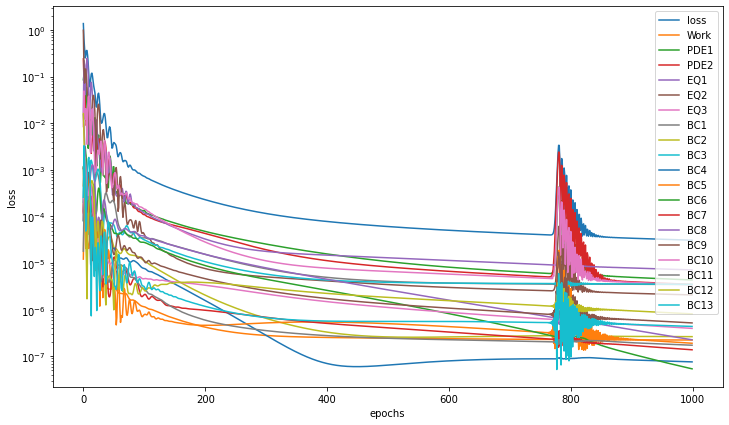

In [14]:
loss_name = ['loss', 'Work', 'PDE1', 'PDE2', 'EQ1', 'EQ2', 'EQ3', 'BC1', 'BC2',
             'BC3', 'BC4', 'BC5', 'BC6', 'BC7', 'BC8', 'BC9', 'BC10', 'BC11', 'BC12', 'BC13']
fig = plt.figure(figsize=(12, 7))
itter = 0 
for word, loss in history.history.items():
        if word.endswith("loss"):
            plt.semilogy(np.array(loss), label=loss_name[itter])
            itter+=1
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')

Text(0, 0.5, 'Total-loss')

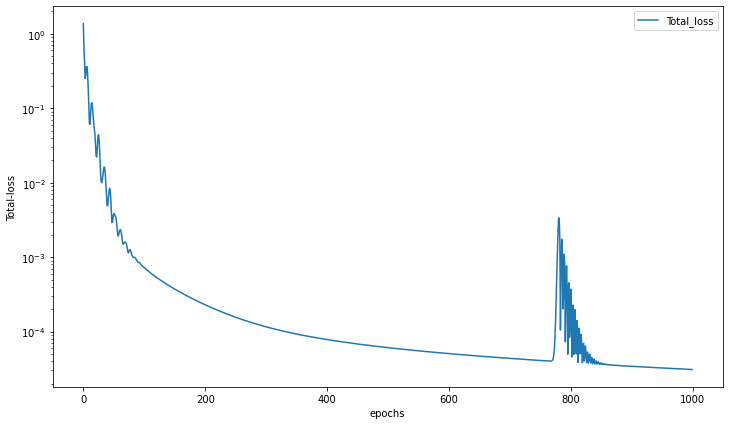

In [15]:
fig = plt.figure(figsize=(12, 7))
plt.semilogy(history.history['loss'], label='Total_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('Total-loss')

**Comparing the network prediction and FE results.**

In [ ]:
# model.load_weights('model_v1.hdf5') # uncomment to show the result after 100k Epochs

In [17]:
u_x_pred = u_x.eval(model, [x_data, y_data, E_data])
u_y_pred = u_y.eval(model, [x_data, y_data, E_data])

sigma_x_pred  = sigma_x.eval(model, [x_data, y_data, E_data])
sigma_y_pred  = sigma_y.eval(model, [x_data, y_data, E_data])
sigma_xy_pred = sigma_xy.eval(model, [x_data, y_data, E_data])

sig_x_O_pred  = sig_x_O.eval(model, [x_data, y_data, E_data])
sig_y_O_pred  = sig_y_O.eval(model, [x_data, y_data, E_data])
sig_xy_O_pred = sig_xy_O.eval(model, [x_data, y_data, E_data])

u_x_error = np.abs(u_x_FE - u_x_pred)
u_y_error = np.abs(u_y_FE - u_y_pred)
sigma_x_error   = np.abs(sigma_x_FE - sigma_x_pred)
sigma_y_error   = np.abs(sigma_y_FE - sigma_y_pred)
sigma_xy_error  = np.abs(sigma_xy_FE - sigma_xy_pred)

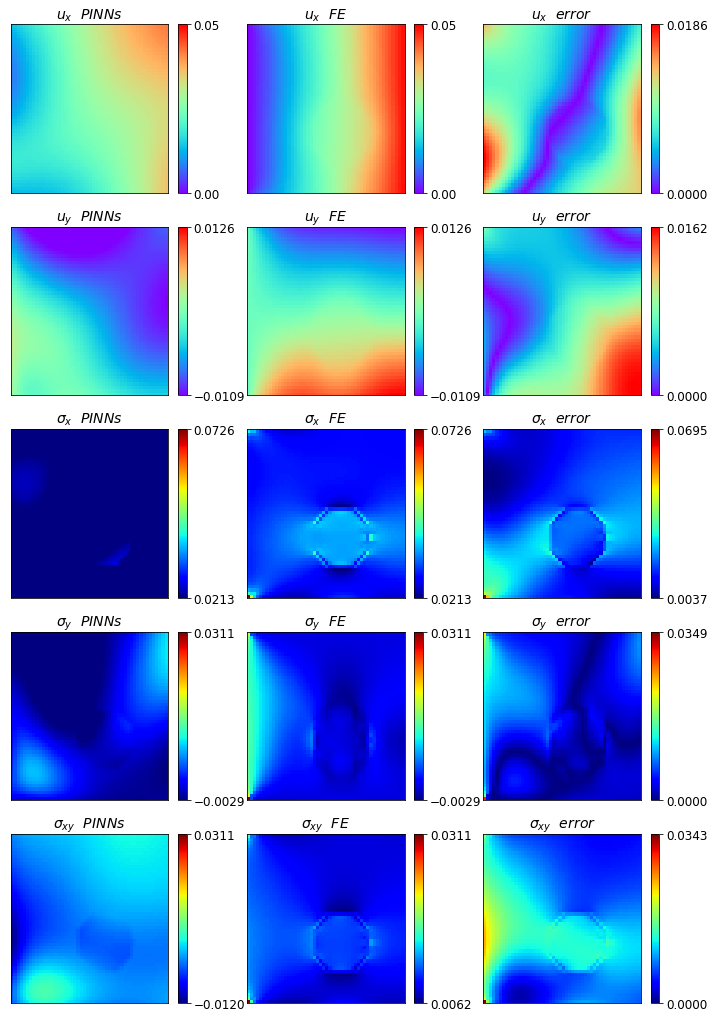

In [18]:
fig,ax = plt.subplots(5,3,figsize=(12,18))
cb= plt.colorbar(ax[0,0].pcolor(x_data, y_data, u_x_pred, cmap='rainbow', vmin=u_x_FE.min(), vmax=u_x_FE.max(), linewidth=0,rasterized=True),ax=ax[0,0], ticks=[u_x_FE.min(),u_x_FE.max()])
cb1=plt.colorbar(ax[0,1].pcolor(x_data, y_data, u_x_FE, cmap='rainbow', vmin=u_x_FE.min(), vmax=u_x_FE.max(), linewidth=0,rasterized=True),ax=ax[0,1], ticks=[u_x_FE.min(),u_x_FE.max()])
cb2=plt.colorbar(ax[0,2].pcolor(x_data, y_data, u_x_error, cmap='rainbow',vmin=0, vmax=np.round(u_x_error.max(),4), linewidth=0,rasterized=True),ax=ax[0,2], ticks=[0,np.round(u_x_error.max(),4)])

cb3=plt.colorbar(ax[1,0].pcolor(x_data, y_data, u_y_pred, cmap='rainbow', vmin=np.round(u_y_FE.min(),4), vmax=np.round(u_y_FE.max(),4), linewidth=0,rasterized=True),ax=ax[1,0], ticks=[np.round(u_y_FE.min(),4),np.round(u_y_FE.max(),4)])
cb4=plt.colorbar(ax[1,1].pcolor(x_data, y_data, u_y_FE, cmap='rainbow', vmin=np.round(u_y_FE.min(),4), vmax=np.round(u_y_FE.max(),4), linewidth=0,rasterized=True),ax=ax[1,1], ticks=[np.round(u_y_FE.min(),4),np.round(u_y_FE.max(),4)])
cb5=plt.colorbar(ax[1,2].pcolor(x_data, y_data, u_y_error, cmap='rainbow',vmin=0, vmax=np.round(u_y_error.max(),4), linewidth=0,rasterized=True),ax=ax[1,2], ticks=[0,np.round(u_y_error.max(),4)])

cb6=plt.colorbar(ax[2,0].pcolor(x_data, y_data, sigma_x_pred, cmap='jet', vmin=np.round(sigma_x_FE.min(),4), vmax=np.round(sigma_x_FE.max(),4), linewidth=0,rasterized=True),ax=ax[2,0], ticks=[np.round(sigma_x_FE.min(),4),np.round(sigma_x_FE.max(),4)])
cb7=plt.colorbar(ax[2,1].pcolor(x_data, y_data, sigma_x_FE, cmap='jet', vmin=np.round(sigma_x_FE.min(),4), vmax=np.round(sigma_x_FE.max(),4), linewidth=0,rasterized=True),ax=ax[2,1], ticks=[np.round(sigma_x_FE.min(),4),np.round(sigma_x_FE.max(),4)])
cb8=plt.colorbar(ax[2,2].pcolor(x_data, y_data, sigma_x_error, cmap='jet', vmin=np.round(sigma_x_error.min(),4), vmax=np.round(sigma_x_error.max(),4), linewidth=0,rasterized=True),ax=ax[2,2], ticks=[np.round(sigma_x_error.min(),4),np.round(sigma_x_error.max(),4)])


cb9=plt.colorbar(ax[3,0].pcolor(x_data, y_data, sigma_y_pred, cmap='jet', vmin=np.round(sigma_y_FE.min(),4), vmax=np.round(sigma_y_FE.max(),4), linewidth=0,rasterized=True),ax=ax[3,0], ticks=[np.round(sigma_y_FE.min(),4),np.round(sigma_y_FE.max(),4)])
cb10=plt.colorbar(ax[3,1].pcolor(x_data, y_data, sigma_y_FE, cmap='jet',vmin=sigma_y_FE.min(), vmax=np.round(sigma_y_FE.max(),4),linewidth=0,rasterized=True),ax=ax[3,1], ticks=[np.round(sigma_y_FE.min(),4),np.round(sigma_y_FE.max(),4)])
cb11=plt.colorbar(ax[3,2].pcolor(x_data, y_data, sigma_y_error, cmap='jet', vmin=np.round(sigma_y_error.min(),4), vmax=np.round(sigma_y_error.max(),4), linewidth=0,rasterized=True),ax=ax[3,2], ticks=[np.round(sigma_y_error.min(),4),np.round(sigma_y_error.max(),4)])

cb12=plt.colorbar(ax[4,0].pcolor(x_data, y_data, sigma_xy_pred, cmap='jet', vmin=np.round(sigma_xy_pred.min(),4), vmax=np.round(sigma_xy_FE.max(),4), linewidth=0,rasterized=True),ax=ax[4,0], ticks=[np.round(sigma_xy_pred.min(),4),np.round(sigma_xy_FE.max(),4)])
cb13=plt.colorbar(ax[4,1].pcolor(x_data, y_data, sigma_xy_FE, cmap='jet', vmin=np.round(sigma_xy_FE.min(),4),vmax=np.round(sigma_xy_FE.max(),4),linewidth=0,rasterized=True),ax=ax[4,1], ticks=[np.round(sigma_xy_FE.min(),4),np.round(sigma_xy_FE.max(),4)])
cb14=plt.colorbar(ax[4,2].pcolor(x_data, y_data, sigma_xy_error, cmap='jet', vmin=0,vmax=sigma_xy_error.max(), linewidth=0,rasterized=True),ax=ax[4,2], ticks=[0,sigma_xy_error.max()])
ax[0,0].set_title(r'$u_x \, \, \, \, PINNs$', fontsize=14), ax[0,1].set_title(r'$u_x \, \, \, \, FE$', fontsize=14), ax[0,2].set_title(r'$u_x \, \, \, \, error$', fontsize=14)
ax[1,0].set_title(r'$u_y \, \, \, \, PINNs$', fontsize=14), ax[1,1].set_title(r'$u_y \, \, \, \, FE$', fontsize=14), ax[1,2].set_title(r'$u_y \, \, \, \, error$', fontsize=14)
ax[2,0].set_title(r"$\sigma_x \, \, \, \, PINNs$ ", fontsize=14), ax[2,1].set_title(r"$\sigma_x \, \, \, \, FE$ ", fontsize=14), ax[2,2].set_title(r"$\sigma_x \, \, \, \, error$ ", fontsize=14)
ax[3,0].set_title(r"$\sigma_y \, \, \, \, PINNs$ ", fontsize=14), ax[3,1].set_title(r"$\sigma_y \, \, \, \, FE$ ", fontsize=14), ax[3,2].set_title(r"$\sigma_y \, \, \, \, error$ ", fontsize=14)
ax[4,0].set_title(r"$\sigma_{xy} \, \, \, \, PINNs$ ", fontsize=14), ax[4,1].set_title(r"$\sigma_{xy} \, \, \, \, FE$ ", fontsize=14), ax[4,2].set_title(r"$\sigma_{xy} \, \, \, \, error$ ", fontsize=14)
ax[0,0].set_yticks([]), ax[0,1].set_yticks([]), ax[0,2].set_yticks([])
ax[1,0].set_yticks([]), ax[1,1].set_yticks([]), ax[1,2].set_yticks([])
ax[2,0].set_yticks([]), ax[2,1].set_yticks([]), ax[2,2].set_yticks([])
ax[3,0].set_yticks([]), ax[3,1].set_yticks([]), ax[3,2].set_yticks([])
ax[4,0].set_yticks([]), ax[4,1].set_yticks([]), ax[4,2].set_yticks([])
ax[0,0].set_xticks([]), ax[0,1].set_xticks([]), ax[0,2].set_xticks([])
ax[1,0].set_xticks([]), ax[1,1].set_xticks([]), ax[1,2].set_xticks([])
ax[2,0].set_xticks([]), ax[2,1].set_xticks([]), ax[2,2].set_xticks([])
ax[3,0].set_xticks([]), ax[3,1].set_xticks([]), ax[3,2].set_xticks([])
ax[4,0].set_xticks([]), ax[4,1].set_xticks([]), ax[4,2].set_xticks([])
cb.ax.tick_params(labelsize=12),cb1.ax.tick_params(labelsize=12),cb2.ax.tick_params(labelsize=12)
cb3.ax.tick_params(labelsize=12),cb4.ax.tick_params(labelsize=12),cb5.ax.tick_params(labelsize=12)
cb6.ax.tick_params(labelsize=12),cb7.ax.tick_params(labelsize=12),cb8.ax.tick_params(labelsize=12)
cb9.ax.tick_params(labelsize=12),cb10.ax.tick_params(labelsize=12),cb11.ax.tick_params(labelsize=12)
cb12.ax.tick_params(labelsize=12),cb13.ax.tick_params(labelsize=12),cb14.ax.tick_params(labelsize=12)
plt.show()

Text(0.5, 1.0, 'Deformed_FE')

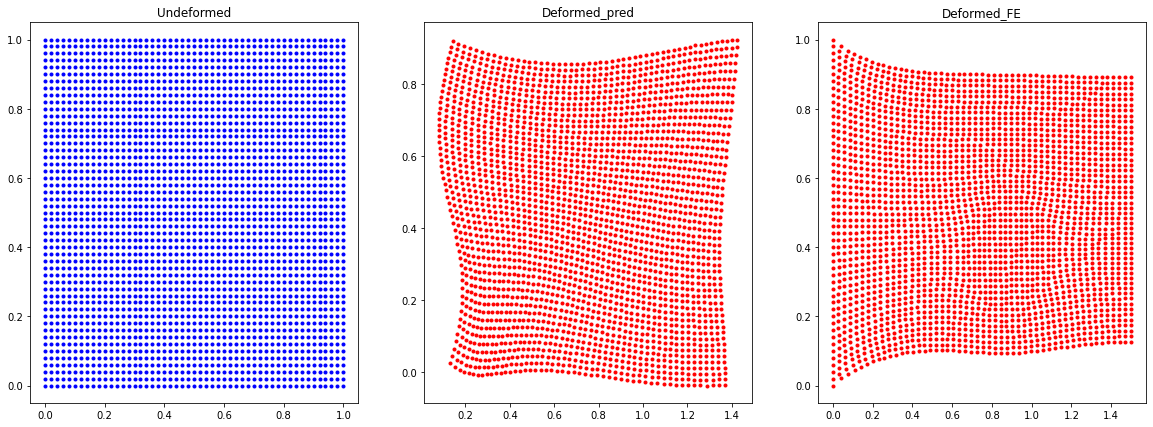

In [19]:
fac = 10
x_new_pred = x_data + u_x_pred*fac
y_new_pred = y_data + u_y_pred*fac
x_new_FE = x_data + u_x_FE*fac
y_new_FE = y_data + u_y_FE*fac

fig,ax = plt.subplots(1,3,figsize=(20,7))
ax[0].plot(x_data, y_data,'b.')
ax[1].plot(x_new_pred, y_new_pred, 'r.')
ax[2].plot(x_new_FE, y_new_FE, 'r.')
ax[0].set_title('Undeformed')
ax[1].set_title('Deformed_pred')
ax[2].set_title('Deformed_FE')